In [245]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize, stats
import numpy as np
import os

import pandas_datareader.data as web

Para este ejercicio, se tomaron ETFs representativos de cada sector, los cuales se mencionan a continuación. El ejercicio consiste en formar un portafolio cuya composición sea similar o mejor al ACWI. A pesar de que se requiere una proyección para el 2025, se toma como base información del 208 y 2019 para el análisis, debido a que las condiciones de mercado han cambiado significativamente y los resultados utilizando información de 5 años atrás pueden ser satisfactorios al realizar un ejercicio de Backtesting, sin embargo, se observaron sectores como el tecnológico (IXN) que no tenían la misma relevancia en periodos anteriores al 2018. 

In [246]:
tickers = ['ACWI','JXI','IXP','RWO','MXI','KXI','IXC','EXI','RXI','IXJ','IXN','IXG']

# Train
start_date = '2018-01-01'
end_date = '2019-12-31'

panel_data = web.DataReader(tickers, 'yahoo', start_date, end_date)


close_prices = panel_data['Close']

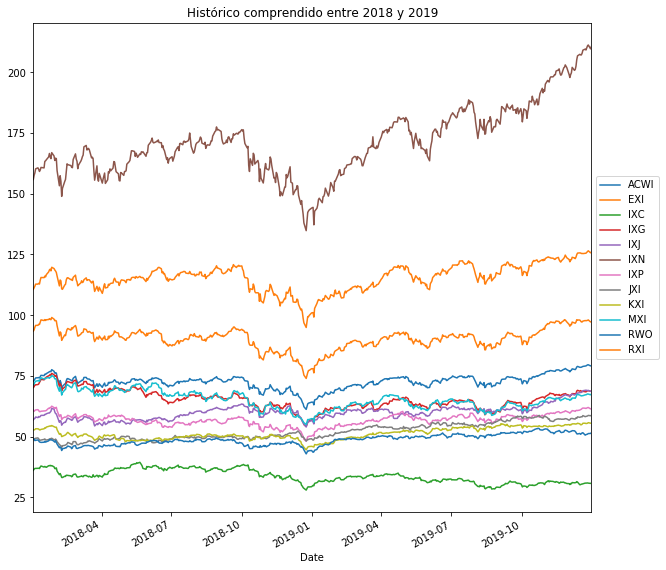

In [311]:
close_prices.plot(figsize=(10,10),title='Histórico comprendido entre 2018 y 2019')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

Con el fin de analizar más detenidamente los ETFs, se estimó el ratio de Sharpe y la beta con el benchmark (ACWI) utilizando las siguientes fórmulas:
$$Sharpe = \frac{r-r_f}{\sqrt{\sigma_{anual}}}$$
$$\beta = \frac{Cov(r,r_{mkt})}{\sigma(r_{mkt})}$$
$$IR = \frac{r-rf}{\sqrt(\sum_{i=1}^{n}(r_i-r_{benchmark})^{2})} \\ $$
Para la tasa de fondeo, al ser ETFs cotizando en US, consideraremos la tasa FED FUNDS, la cual está en 1.75%.


In [248]:
returns = close_prices.pct_change().dropna()
acwi = returns['ACWI']
returns.drop('ACWI',axis=1,inplace=True)
cov_matrix = returns.cov() * 252
means = returns.mean() * 252
weights0 = np.array((len(tickers)-1)*[1/(len(tickers)-1)])
rf = 0.0175

In [249]:
betas = [stats.linregress(returns[i].values,acwi.values)[0] for i in returns.columns]

pd.DataFrame({'Sharpe Ratio %':100*(252*returns.mean()-rf)/(returns.std()*np.sqrt(252)),
              'Information Ratio':(252*returns.mean()-rf)/((returns.sub(acwi,axis='index'))**2).sum(),
              'Beta' : betas})

,Sharpe Ratio %,Information Ratio,Beta
Symbols,,,
EXI,9.524324,2.111093,0.846175
IXC,-42.448284,-2.681707,0.563412
IXG,-10.738406,-1.935227,0.828536
IXJ,62.454713,8.153288,0.852648
IXN,74.467758,8.401446,0.615477
IXP,-1.919714,-0.223552,0.794441
JXI,68.188838,2.071921,0.534172
KXI,12.597397,0.768240,0.900392
MXI,-17.507427,-2.451160,0.730413


De los resultados anteriores, vemos que el ETF relacionado con tecnologías (IXN) tiene un ratio de Sharpe Significativamente mayor al resto de ETF (algunos incluso tienen ratios negativos). Asumiremos que dado a que queremos replicar el comportamiento de un benchmark, no es posible hacer ventas en corto, lo cual limita considerablemente el universo de inversión. Además con una beta del 65%, vemos que la exposición al mercado de este subyacente es relativamente poca.

En la siguiente sección se exponen las funciones utilizadas para estimar los rendimientos de un portafolio, así como su volatilidad y el ratio de sharpe.

In [266]:
def beta_func(y,x):
    [beta, alpha] = stats.linregress(x,y)[0]
    return beta

def ret_port(weights,means):
    return means.dot(weights)

def vol_port(weights,cov_matrix):
    return np.sqrt(cov_matrix.dot(weights).dot(weights.T))

def sharpe_ratio_neg(weights,means, cov_matrix,rf):
    r = ret_port(weights,means)
    v = vol_port(weights,cov_matrix)
    return -(r-rf)/v

def info_ratio(weights,returns,benchmark,rf):
    portfolio = returns.dot(weights)
    tracking_error = np.sqrt(((portfolio - benchmark)**2).sum())
    return((portfolio.mean()-rf)/tracking_error)

Se realizaron diversas pruebas para obtener un portafolio que tenga rendimientos por encima del ACWI cuidando el nivel de volatilidad (riesgo) asumido. Por lo que se plantearon diveras optimizaciones tomando com base el método de markowitz con las siguientes características:


$\\ min \ \sigma_p(w_1,w_2,...,w_n) \\ \\ s.t.\sum_{i=1}^{n}w_i = 1 \\ w_i \geq 0 \ \forall \ i = 1,2,...,n$

$\\ max \ Sharpe \ ratio(w_1,w_2,...,w_n) \\ \\ s.t.\sum_{i=1}^{n}w_i = 1 \\ w_i \geq 0 \ \forall \ i = 1,2,...,n$

$\\ min \ Information \ Ratio (w_1,w_2,...,w_n) \\ \\ s.t.\sum_{i=1}^{n}w_i = 1 \\ w_i \geq 0 \ \forall \ i = 1,2,...,n$

El siguiente código  optimiza los pesos de acuerdo con cada uno de los criterios mencionados anteriormente:

In [315]:
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})

bnds = [(0.0,1.0) for k in range(len(tickers)-1)]

max_sharpe = optimize.minimize(sharpe_ratio_neg, weights0,
                              args =(means, cov_matrix,rf),
                              method = 'SLSQP',constraints=cons,
                              bounds = bnds)

min_info_ratio = optimize.minimize(info_ratio, weights0,
                                  args =(returns,acwi,rf),
                                  method = 'SLSQP',constraints=cons,
                                  bounds = bnds)

min_variance = optimize.minimize(vol_port, weights0,
                              args =(cov_matrix),
                              method = 'SLSQP',constraints=cons,
                              bounds = bnds)

Con el fin de tener una comparación de estas optimizaciones, obtendremos la frontera eficiente del problema resolviendo el siguiente problema:

$\\ min \ \sigma_p(w_1,w_2,...,w_n) \\ \\ s.t.\sum_{i=1}^{n}w_i = 1 \\ r_p = \mu \\ w_i \geq 0 \ \forall \ i = 1,2,...,n$

In [268]:
trets = np.linspace(0.05, 0.20, 100)
tvols = []

cons = ({'type': 'eq', 'fun': lambda x:  ret_port(x,means) - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})

for tret in trets:
    res = optimize.minimize(vol_port, weights0, args=(cov_matrix), method='SLSQP',
                       bounds=bnds, constraints=cons)  
    tvols.append(res.fun)
tvols = np.array(tvols)

Oservando los resultados obtenidos en la gráfica, vemos que no es directo seleccionar uno de los tres portafolios propuestos dado que todos tienen asociados un nivel de riesgo mayor por cada unidad de rendimiento ganada, sin embargo, al tomar el portafolio obtenido maximizando el ratio de sharpe, vemos que podemos realizar una combinación lineal entre dicho portafolio y nuestro instrumento de fondeo (FED FUND RATE) y encontrar un mapeo de cada portafolio con su respectivo portafolio en la linea mencionada (Capital Asset Line).

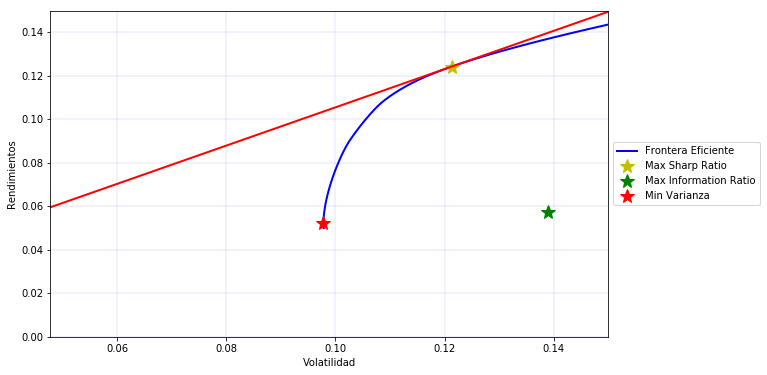

In [316]:
eqn_of_the_line = lambda x : ( (ret_port(max_sharpe['x'],means)-rf) / 
                              vol_port(max_sharpe['x'],cov_matrix) ) * x + rf

plt.figure(figsize=(10, 6))

plt.plot(tvols, trets, 'b', lw=2.0,label='Frontera Eficiente')

plt.plot(vol_port(max_sharpe['x'],cov_matrix), ret_port(max_sharpe['x'],means),
         'y*', markersize=15.0,label='Max Sharp Ratio')

plt.plot(vol_port(min_info_ratio['x'],cov_matrix), ret_port(min_info_ratio['x'],means),
         'g*', markersize=15.0,label='Max Information Ratio')

plt.plot(vol_port(min_variance['x'],cov_matrix), ret_port(min_variance['x'],means),
         'r*', markersize=15.0,label = 'Min Varianza')

xrange = np.linspace(0.0, 0.24, num=11)

plt.plot(xrange, [eqn_of_the_line(x) for x in xrange], color='red', 
         linestyle='-', linewidth=2)
plt.grid(color='b', linestyle='-', linewidth=.1);

plt.xlabel('Volatilidad')
plt.ylabel('Rendimientos')
plt.legend()
plt.ylim(0,0.15);
plt.xlim(vol_port(min_variance['x'],cov_matrix)-0.05,0.15);
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show();

Los pesos resultantes para cada portafolio se muestran a continuación. Vemos que Utilities (JXI) y Tech (IXN) aparecen en el portafolio de Sharpe.

In [317]:
weights_df =pd.DataFrame({'W Sharpe':max_sharpe['x'],
             'W info ratio':min_info_ratio['x'],
             'W min variance': min_variance['x']}, index = returns.columns).applymap(lambda x: round(x,5))
weights_df

,W Sharpe,W info ratio,W min variance
Symbols,,,
EXI,0.00000,0.06038,0.00000
IXC,0.00000,0.05593,0.02408
IXG,0.00000,0.17912,0.12168
IXJ,0.00000,0.11737,0.00000
IXN,0.38784,0.19775,0.00000
IXP,0.00000,0.06464,0.00000
JXI,0.61216,0.02068,0.41919
KXI,0.00000,0.08397,0.22466
MXI,0.00000,0.09634,0.00000


Vemos que el ratio de sharpe es relativamente bajo para todos los portafolios, por lo que podemos tomar posición en Fondo sobre el portafolio de sharpe sin disminuir demasiado nuestros rendimientos. 

In [293]:
df = pd.DataFrame({'port_sharpe' : returns.dot(max_sharpe['x']).values,
             'port_ir' : returns.dot(max_info_ratio['x']).values,
             'port_min_var' : returns.dot(min_variance['x']).values,
             'ACWI' : acwi.values},index = acwi.index)

names = ['port_sharpe','port_ir','port_min_var']
betas = [stats.linregress(df[i].values,df['ACWI'].values)[0] for i in names]
betas.append(1)



pd.DataFrame({'Sharpe Ratio %':100*(252*df.mean()-rf)/(df.std()*np.sqrt(252)),
              'Beta' : betas})

,Sharpe Ratio %,Beta
port_sharpe,88.025741,0.982108
port_ir,28.569161,0.994188
port_min_var,35.428908,1.063889
ACWI,25.188449,1.000000


Hicimos con estos pesos un ejercicio de backTesting del 2015 a la fecha. Observamos que el portafolio correspondiente al Information Ratio es muy similar al ACWI. Teniendo ganancias marginales con respecto a dicho ETF. Sin embargo, vemos reflejado en el portafolio de Sharpe un renfdimiento mejor en el último periodo. Ésto es obvio por la ventana de tiempo que utilizamos para estimar los pesos del modelo. Dicho lo anterior, 

In [271]:
# Testing
start_date_test = '2015-01-01'
end_date_test = '2019-12-31'

panel_data_test = web.DataReader(tickers, 'yahoo', start_date_test, end_date_test)

close_prices_test = panel_data_test['Close']

returns_test = close_prices_test.pct_change().dropna()
acwi_test = returns_test['ACWI']
returns_test.drop('ACWI',axis=1,inplace=True)

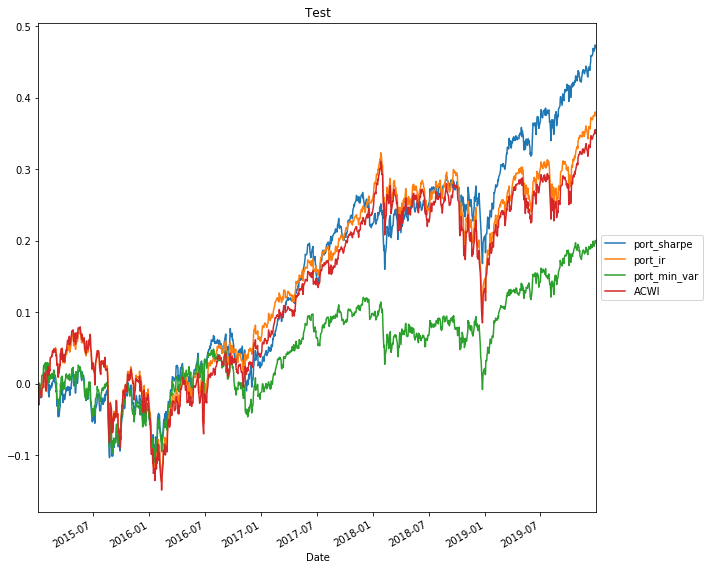

In [273]:
df_rets = pd.DataFrame({'port_sharpe' : returns_test.dot(max_sharpe['x']).values,
             'port_ir' : returns_test.dot(max_info_ratio['x']).values,
             'port_min_var' : returns_test.dot(min_variance['x']).values,
             'ACWI' : acwi_test.values},index = acwi_test.index)
df = df_rets.cumsum()
df.plot(figsize=(10,10),title ='Test');
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show();

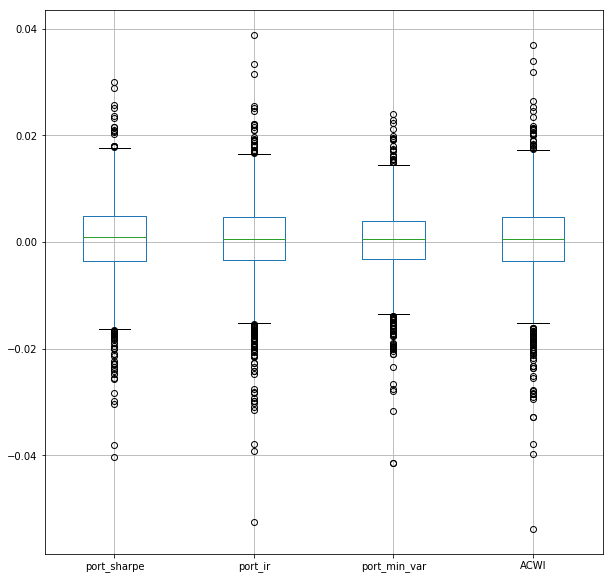

In [294]:
df_rets.boxplot(figsize=(10,10));

Conclusiones: 

Sea $R_P$ el rendimiento del portafolio de Sharpe, Si hacemos una combinación lineal entre el rendimiento de portafolio de sharpe y la tasa de fondeo podemos encontrar el rendimiento de un portafolio con el mismo nivel de vol que el de minima varianza, éste lo tomaremos como nuestro portafolio seleccionado:

In [305]:
R_portafolio =(ret_port(max_sharpe['x'],means)-rf) / vol_port(max_sharpe['x'],cov_matrix) * vol_port(min_variance['x'],cov_matrix) + rf
perc_fondeo = (R_portafolio-ret_port(max_sharpe['x'],means))/(rf-ret_port(max_sharpe['x'],means))
weights_df['Final'] = weights_df['W Sharpe']*(1-perc_fondeo)

In [309]:
weights_df

,W Sharpe,W info ratio,W min variance,Final
Symbols,,,,
EXI,0.00000,0.06038,0.00000,0.000000
IXC,0.00000,0.05593,0.02408,0.000000
IXG,0.00000,0.17912,0.12168,0.000000
IXJ,0.00000,0.11737,0.00000,0.000000
IXN,0.38784,0.19775,0.00000,0.312766
IXP,0.00000,0.06464,0.00000,0.000000
JXI,0.61216,0.02068,0.41919,0.493665
KXI,0.00000,0.08397,0.22466,0.000000
MXI,0.00000,0.09634,0.00000,0.000000


In [310]:
perc_fondeo

0.19356914581695697